# Objective
* Determine if logistic regression can be done with a non-gigantic amount of variables, and if so, which variables

First, we import the necessary libraries and get a first look at the data.

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

# + blue side lead, - red side lead, warding numbers wonky, timer variables in seconds

In [90]:
dirname = '' #hackathon-riot-data/ on Sarah's computer
df = pd.read_csv(dirname+'hackathon-riot-data.csv', sep=';')
pd.set_option('display.max_columns', None)
df.rename(columns={'GoldDiff10Bot':'GoldDiffSup10', 
                   'XPDiff10Bot':'XPDiffSup10',
                   'GoldDiff15Bot':'GoldDiffSup15',
                   'XPDiff15Bot':'XPDiffSup15',
                   'GoldDiffEndBot':'GoldDiffEndSup',
                   'XPDiffEndBot':'XPDiffEndSup'}, inplace=True)

# dataframe for potentially relevant features
features_df = pd.DataFrame()

In [58]:
# ID doesn't influence who wins, ward numbers are unreliable, other columns are redundant or difficult to use
df.drop(columns=['esportsPlatformId', 
                 'NbWardsPlacedBlue', 
                 'NbWardsPlacedRed', 
                 'NbControlWardsPlacedBlue', 
                 'NbControlWardsPlacedRed', 
                 'NbWardsKilledBlue', 
                 'NbWardsKilledRed', 
                 'NbControlWardsKilledBlue', 
                 'NbControlWardsKilledRed', 
                 'NbCampsSecuredBlue', 
                 'NbCampsSecuredRed',
                 'NbScuttlesBlue',
                 'NbScuttlesRed',
                 'NbDragonsBlue',
                 'NbDragonsRed',
                 'NbBaronsBlue',
                 'NbBaronsRed',
                 'NbEldersBlue',
                 'NbEldersRed',
                 'DragonSoulTimer',
                 'DragonSoulType',
                 'DragonSoulTaker',
                 'DragonSoulTeam'], inplace=True)

First, we need to check for missing values and address them appropriately, see if any can be replaced or if the row they belong to must be dropped.

In [59]:
col_list = df.columns.tolist()

for col in col_list:
    if df[col].isnull().sum() != 0:
        print(col.ljust(25), str(df[col].isnull().sum()).rjust(5))

gameDate                      3
gameVersion                   3
gameDuration                  3
OuterTopBlueTimer          3105
OuterMidBlueTimer          4976
OuterBotBlueTimer          2874
InnerTopBlueTimer         11699
InnerMidBlueTimer          8947
InnerBotBlueTimer         10211
BaseTopBlueTimer          15866
BaseMidBlueTimer          11583
BaseBotBlueTimer          14357
Nexus1MidBlueTimer        10208
Nexus2MidBlueTimer        10351
OuterTopRedTimer           2221
OuterMidRedTimer           3524
OuterBotRedTimer           2409
InnerTopRedTimer          10169
InnerMidRedTimer           7454
InnerBotRedTimer           9202
BaseTopRedTimer           15082
BaseMidRedTimer           10425
BaseBotRedTimer           13452
Nexus1MidRedTimer          9035
Nexus2MidRedTimer          9232
GoldTopBlue10                 3
GoldJgBlue10                  3
GoldMidBlue10                 3
GoldADBlue10                  3
GoldSupBlue10                 3
GoldTopRed10                  3
GoldJgRe

In [60]:
# can't use a row without the winner label since that's what is being predicted
missing_label_row = (df['winner'].isna() == True)
df.drop(index=df[missing_label_row].index, inplace=True)

# 3 random rows with a lot of NaNs
nan_rows = (df['gameDate'].isna() == True)
df.drop(index=df[nan_rows].index, inplace=True)
df.reset_index(drop=True, inplace=True)

# Adel's addition: any rows that have a gameDuration of 7000 indicate incomplete data.
duration_not_found = (df['gameDuration'] > 7000)
df.drop(index=df[duration_not_found].index, inplace=True)
df.reset_index(drop=True, inplace=True)

# NaN represents a turret was never taken, so it can be replaced with the game duration
# doing this with a loop because of some setting copy error
for col in col_list:
    if df[col].isnull().sum() != 0:
        df[col].fillna(df['gameDuration'], inplace=True)

In [61]:
# some features to look at later
features_df['winner'] = df['winner']
features_df['gameDurationMin'] = (df['gameDuration'] / 60)
features_df['BlueTowerKillsEnd'] = df['BlueTowerKillsEnd']
features_df['RedTowerKillsEnd'] = df['RedTowerKillsEnd']
features_df['BlueInhibKillsEnd'] = df['BlueInhibKillsEnd']
features_df['RedInhibKillsEnd'] = df['RedInhibKillsEnd']
features_df['BlueBaronKillsEnd'] = df['BlueBaronKillsEnd']
features_df['RedBaronKillsEnd'] = df['RedBaronKillsEnd']
features_df['BlueDragonKillsEnd'] = df['BlueDragonKillsEnd']
features_df['RedDragonKillsEnd'] = df['RedDragonKillsEnd']

We can reduce the remaining columns by consolidating. For example, we are given various stats like gold, xp, vision score, cc duration, damage dealt, and damage taken for each role. These can be totaled. Consolidation will also make modeling easier. There may be nuances to consider, such as possibly keeping the gold of adc separate since esports games favor funneling the adc, especially if more competitive tournaments tend to have longer matches (adc shines late game), but for now we simply want an mvp.

In [62]:
# columns for total gold already exist
df.drop(columns=['GoldTopBlue10', 'GoldJgBlue10', 'GoldMidBlue10', 'GoldADBlue10', 'GoldSupBlue10',
                 'GoldTopRed10', 'GoldJgRed10', 'GoldMidRed10', 'GoldADRed10', 'GoldSupRed10',
                 'GoldTopBlue15', 'GoldJgBlue15', 'GoldMidBlue15', 'GoldADBlue15', 'GoldSupBlue15',
                 'GoldTopRed15', 'GoldJgRed15', 'GoldMidRed15', 'GoldADRed15', 'GoldSupRed15',
                 'GoldTopBlueEnd', 'GoldJgBlueEnd', 'GoldMidBlueEnd', 'GoldADBlueEnd', 'GoldSupBlueEnd',
                 'GoldTopRedEnd', 'GoldJgRedEnd', 'GoldMidRedEnd', 'GoldADRedEnd', 'GoldSupRedEnd'], inplace=True)

#3 outliers not going to predict anything because these values are 0 for the rest of the rows
df.drop(columns=['BlueInhibKills15', 'RedInhibKills15'], inplace=True)

# calculating totals then dropping the columns for individual stats
features_df['GoldDiff10'] = df['BlueTotalGold10'] - df['RedTotalGold10']
df.drop(columns=['GoldDiff10Top', 'GoldDiff10Jg', 'GoldDiff10Mid', 'GoldDiff10AD', 'GoldDiffSup10'], inplace=True)

features_df['GoldDiff15'] = df['BlueTotalGold15'] - df['RedTotalGold15']
df.drop(columns=['GoldDiff15Top', 'GoldDiff15Jg', 'GoldDiff15Mid', 'GoldDiff15AD', 'GoldDiffSup15'], inplace=True)

features_df['GoldDiffEnd'] = df['BlueTotalGoldEnd'] - df['RedTotalGoldEnd']
df.drop(columns=['GoldDiffEndTop', 'GoldDiffEndJg', 'GoldDiffEndMid', 'GoldDiffEndAD', 'GoldDiffEndSup'], inplace=True)

features_df['XPDiff10'] = df['XPDiff10Top'] + df['XPDiff10Jg'] + df['XPDiff10Mid'] + df['XPDiff10AD'] + df['XPDiffSup10']
df.drop(columns=['XPDiff10Top', 'XPDiff10Jg', 'XPDiff10Mid', 'XPDiff10AD', 'XPDiffSup10'], inplace=True)

features_df['XPDiff15'] = df['XPDiff15Top'] + df['XPDiff15Jg'] + df['XPDiff15Mid'] + df['XPDiff15AD'] + df['XPDiffSup15']
df.drop(columns=['XPDiff15Top', 'XPDiff15Jg', 'XPDiff15Mid', 'XPDiff15AD', 'XPDiffSup15'], inplace=True)

features_df['XPDiffEnd'] = df['XPDiffEndTop'] + df['XPDiffEndJg'] + df['XPDiffEndMid'] + df['XPDiffEndAD'] + df['XPDiffEndSup']
df.drop(columns=['XPDiffEndTop', 'XPDiffEndJg', 'XPDiffEndMid', 'XPDiffEndAD', 'XPDiffEndSup'], inplace=True)

features_df['VisionScoreBlue'] = df['VisionScoreTopBlue'] + df['VisionScoreJgBlue'] + df['VisionScoreMidBlue'] + df['VisionScoreADBlue'] + df['VisionScoreSupBlue']
df.drop(columns=['VisionScoreTopBlue', 'VisionScoreJgBlue', 'VisionScoreMidBlue', 'VisionScoreADBlue', 'VisionScoreSupBlue'], inplace=True)

features_df['VisionScoreRed'] = df['VisionScoreTopRed'] + df['VisionScoreJgRed'] + df['VisionScoreMidRed'] + df['VisionScoreADRed'] + df['VisionScoreSupRed']
df.drop(columns=['VisionScoreTopRed', 'VisionScoreJgRed', 'VisionScoreMidRed', 'VisionScoreADRed', 'VisionScoreSupRed'], inplace=True)

features_df['DmgDealtBlue'] = df['DamageDealtTopBlue'] + df['DamageDealtJgBlue'] + df['DamageDealtMidBlue'] + df['DamageDealtADBlue'] + df['DamageDealtSupBlue']
df.drop(columns=['DamageDealtTopBlue', 'DamageDealtJgBlue', 'DamageDealtMidBlue', 'DamageDealtADBlue', 'DamageDealtSupBlue'], inplace=True)

features_df['DmgDealtRed'] = df['DamageDealtTopRed'] + df['DamageDealtJgRed'] + df['DamageDealtMidRed'] + df['DamageDealtADRed'] + df['DamageDealtSupRed']
df.drop(columns=['DamageDealtTopRed', 'DamageDealtJgRed', 'DamageDealtMidRed', 'DamageDealtADRed', 'DamageDealtSupRed'], inplace=True)

features_df['DmgTakenBlue'] = df['DamageTakenTopBlue'] + df['DamageTakenJgBlue'] + df['DamageTakenMidBlue'] + df['DamageTakenADBlue'] + df['DamageTakenSupBlue']
df.drop(columns=['DamageTakenTopBlue', 'DamageTakenJgBlue', 'DamageTakenMidBlue', 'DamageTakenADBlue', 'DamageTakenSupBlue'], inplace=True)

features_df['DmgTakenRed'] = df['DamageTakenTopRed'] + df['DamageTakenJgRed'] + df['DamageTakenMidRed'] + df['DamageTakenADRed'] + df['DamageTakenSupRed']
df.drop(columns=['DamageTakenTopRed', 'DamageTakenJgRed', 'DamageTakenMidRed', 'DamageTakenADRed', 'DamageTakenSupRed'], inplace=True)

df['TotalCCBlue'] = df['TotalCCDurationTopBlue'] + df['TotalCCDurationJgBlue'] + df['TotalCCDurationMidBlue'] + df['TotalCCDurationADBlue'] + df['TotalCCDurationSupBlue']
df.drop(columns=['TotalCCDurationTopBlue', 'TotalCCDurationJgBlue', 'TotalCCDurationMidBlue', 'TotalCCDurationADBlue', 'TotalCCDurationSupBlue'], inplace=True)

df['TotalCCRed'] = df['TotalCCDurationTopRed'] + df['TotalCCDurationJgRed'] + df['TotalCCDurationMidRed'] + df['TotalCCDurationADRed'] + df['TotalCCDurationSupRed']
df.drop(columns=['TotalCCDurationTopRed', 'TotalCCDurationJgRed', 'TotalCCDurationMidRed', 'TotalCCDurationADRed', 'TotalCCDurationSupRed'], inplace=True)

In [63]:
# calculating ADR, assists/death ratio
# make copy of deaths col, fill 0s with 1s, calculate, replace filled col with copy because deaths = 0 means divide by 1
df['BlueDeaths10Copy'] = df['BlueDeaths10']
df['BlueDeaths10'].replace(0.0, 1.0, inplace=True)
features_df['BlueADR10'] = (df['BlueAssists10'] / df['BlueDeaths10'])
df['BlueDeaths10'] = df['BlueDeaths10Copy']
df.drop(columns=['BlueDeaths10Copy'], inplace=True)

df['BlueDeaths15Copy'] = df['BlueDeaths15']
df['BlueDeaths15'].replace(0.0, 1.0, inplace=True)
features_df['BlueADR15'] = (df['BlueAssists15'] / df['BlueDeaths15'])
df['BlueDeaths15'] = df['BlueDeaths15Copy']
df.drop(columns=['BlueDeaths15Copy'], inplace=True)

df['BlueDeathsEndCopy'] = df['BlueDeathsEnd']
df['BlueDeathsEnd'].replace(0.0, 1.0, inplace=True)
features_df['BlueADREnd'] = (df['BlueAssistsEnd'] / df['BlueDeathsEnd'])
df['BlueDeathsEnd'] = df['BlueDeathsEndCopy']
df.drop(columns=['BlueDeathsEndCopy'], inplace=True)

df['RedDeaths10Copy'] = df['RedDeaths10']
df['RedDeaths10'].replace(0.0, 1.0, inplace=True)
features_df['RedADR10'] = (df['RedAssists10'] / df['RedDeaths10'])
df['RedDeaths10'] = df['RedDeaths10Copy']
df.drop(columns=['RedDeaths10Copy'], inplace=True)

df['RedDeaths15Copy'] = df['RedDeaths15']
df['RedDeaths15'].replace(0.0, 1.0, inplace=True)
features_df['RedADR15'] = (df['RedAssists15'] / df['RedDeaths15'])
df['RedDeaths15'] = df['RedDeaths15Copy']
df.drop(columns=['RedDeaths15Copy'], inplace=True)

df['RedDeathsEndCopy'] = df['RedDeathsEnd']
df['RedDeathsEnd'].replace(0.0, 1.0, inplace=True)
features_df['RedADREnd'] = (df['RedAssistsEnd'] / df['RedDeathsEnd'])
df['RedDeathsEnd'] = df['RedDeathsEndCopy']
df.drop(columns=['RedDeathsEndCopy'], inplace=True)

In [64]:
features_df

,winner,gameDurationMin,BlueTowerKillsEnd,RedTowerKillsEnd,BlueInhibKillsEnd,RedInhibKillsEnd,BlueBaronKillsEnd,RedBaronKillsEnd,BlueDragonKillsEnd,RedDragonKillsEnd,GoldDiff10,GoldDiff15,GoldDiffEnd,XPDiff10,XPDiff15,XPDiffEnd,VisionScoreBlue,VisionScoreRed,DmgDealtBlue,DmgDealtRed,DmgTakenBlue,DmgTakenRed,BlueADR10,BlueADR15,BlueADREnd,RedADR10,RedADR15,RedADREnd
0,red,34.471133,3.0,11.0,0.0,1.0,0.0,1.0,1.0,2.0,-1354.0,-3861.0,-9815.0,-818.0,-2022.0,-7128.0,156.724674,203.646418,76784.784668,111060.248535,131734.996094,112710.541992,0.0,0.111111,0.966667,4.0,3.333333,2.647059
1,red,33.330317,2.0,10.0,0.0,2.0,0.0,2.0,0.0,4.0,-920.0,-1274.0,-12002.0,-434.0,-699.0,-11571.0,238.711369,298.544613,75103.252197,93868.016602,118238.287109,116021.859375,0.0,3.000000,0.800000,0.0,2.000000,8.200000
2,blue,31.379383,9.0,2.0,1.0,0.0,1.0,0.0,2.0,2.0,722.0,2318.0,11246.0,1067.0,780.0,9486.0,264.830082,224.835535,51793.047607,44358.151367,83805.064453,77475.759766,3.0,1.666667,5.666667,1.0,1.666667,1.000000
3,blue,25.855733,7.0,1.0,1.0,0.0,1.0,0.0,3.0,1.0,1892.0,820.0,9751.0,893.0,-1012.0,10209.0,163.739124,154.203134,47477.142334,38891.236572,66697.954102,69003.676758,5.5,2.800000,5.222222,0.6,2.166667,1.052632
4,red,37.449000,4.0,9.0,0.0,1.0,0.0,1.0,2.0,2.0,710.0,-439.0,-9545.0,-61.0,1413.0,-12037.0,269.936127,277.164185,68731.898682,76759.528809,107434.735352,102052.777344,1.0,2.000000,1.666667,0.0,0.400000,2.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19733,blue,41.256083,7.0,7.0,1.0,0.0,2.0,1.0,3.0,3.0,-998.0,-879.0,1377.0,-393.0,-1338.0,3900.0,363.980244,372.348934,107750.124023,94517.742188,128364.878906,146959.968750,0.5,0.333333,2.095238,2.0,5.000000,2.238095
19734,blue,25.372850,9.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0,-157.0,-654.0,10619.0,-1127.0,-1709.0,8948.0,140.733849,139.382868,64050.456055,46774.285156,65328.648438,80371.787109,0.0,2.666667,6.500000,0.0,1.250000,0.823529
19735,red,35.050017,3.0,9.0,0.0,1.0,0.0,2.0,1.0,4.0,-1021.0,-4.0,-12009.0,-271.0,-160.0,-12698.0,236.265320,285.348082,50280.660645,77062.770020,95487.943359,75354.740723,1.0,4.333333,1.200000,4.0,1.200000,6.142857
19736,red,31.840933,3.0,10.0,0.0,1.0,0.0,2.0,0.0,5.0,-548.0,1710.0,-10577.0,-535.0,747.0,-15111.0,242.919640,285.430437,57810.262451,104446.147461,125335.755859,88453.358398,1.0,2.500000,0.571429,1.0,0.800000,9.000000


In [65]:
features_df['gameDurationMin'].describe()

count    19738.000000
mean        33.446872
std          6.487052
min         16.945233
25%         29.099962
50%         32.493675
75%         36.918929
max        111.950017
Name: gameDurationMin, dtype: float64

Given that the average game duration is 33 minutes, it's worth looking at features at the 15 minute mark since that's about half the game, and because it captures early game performance.

We want to look at features that don't completely correlate with each other. It's like having linearly dependent columns in a matrix; linearly dependent columns don't add extra space all the vectors can reach, so they don't offer new information.

In [66]:
correlation10 = features_df['GoldDiff10'].corr(features_df['XPDiff10'])
correlation15 = features_df['GoldDiff15'].corr(features_df['XPDiff15'])
correlationEnd = features_df['GoldDiffEnd'].corr(features_df['XPDiffEnd'])

print('Gold and XP correlation at 10: ', correlation10, end='\n')
print('Gold and XP correlation at 15: ', correlation15, end='\n')
print('Gold and XP correlation at End: ', correlationEnd, end='\n')

Gold and XP correlation at 10:  0.7700011879470277
Gold and XP correlation at 15:  0.8027846362150703
Gold and XP correlation at End:  0.9614894609585475


The correlation between gold difference and xp difference increases as a game progresses. Correlation coefficients of about 0.7+ correspond to a strong linear relationship, so we can forego XP difference columns and just look at gold differences. This makes sense since having more gold = more items a team can use to further their lead.

In [67]:
metrics_df = pd.DataFrame()
# @ 15 min and @ end
    # gold diff/min
    # ADR, assists/death ratio
# vision score diff/min
# objective diff (turrets, inhibs, drakes, barons)
metrics_df['winner'] = features_df['winner']
metrics_df['GoldDiffPerMin15'] = (features_df['GoldDiff15'] / features_df['gameDurationMin'])
metrics_df['GoldDiffPerMinEnd'] = (features_df['GoldDiffEnd'] / features_df['gameDurationMin'])
metrics_df['ADRDiff15'] = (features_df['BlueADR15'] - features_df['RedADR15'])
metrics_df['ADRDiffEnd'] = (features_df['BlueADREnd'] - features_df['RedADREnd'])
metrics_df['VisionScoreDiffPerMin'] = ((features_df['VisionScoreBlue'] - features_df['VisionScoreRed']) / features_df['gameDurationMin'])
metrics_df['TowerPlusInhibDiff'] = (features_df['BlueTowerKillsEnd'] + features_df['BlueInhibKillsEnd'] - features_df['RedTowerKillsEnd'] - features_df['RedInhibKillsEnd'])
metrics_df['DrakeAndBaronDiff'] = (features_df['BlueDragonKillsEnd'] + features_df['BlueBaronKillsEnd'] - features_df['RedDragonKillsEnd'] + features_df['RedBaronKillsEnd'])
metrics_df['ObjectiveDiff'] = (metrics_df['TowerPlusInhibDiff'] + metrics_df['DrakeAndBaronDiff'])

metrics_df.drop(columns=['TowerPlusInhibDiff', 'DrakeAndBaronDiff'], inplace=True)
metrics_df['ObjectiveDiff'] = metrics_df['ObjectiveDiff'].astype(int)

In [68]:
metrics_df

,winner,GoldDiffPerMin15,GoldDiffPerMinEnd,ADRDiff15,ADRDiffEnd,VisionScoreDiffPerMin,ObjectiveDiff
0,red,-112.006761,-284.730992,-3.222222,-1.680392,-1.361189,-9
1,red,-38.223459,-360.092588,1.000000,-7.400000,-1.795160,-12
2,blue,73.870158,358.388177,0.000000,4.666667,1.274549,9
3,blue,31.714436,377.131055,0.633333,4.169591,0.368815,10
4,red,-11.722609,-254.879970,1.600000,-0.833333,-0.193011,-5
...,...,...,...,...,...,...,...
19733,blue,-21.305949,33.376896,-4.666667,-0.142857,-0.202847,4
19734,blue,-25.775583,418.518219,1.416667,5.676471,0.053245,9
19735,red,-0.114123,-342.624659,3.133333,-4.942857,-1.400363,-8
19736,red,53.704456,-332.182474,1.700000,-8.428571,-1.335099,-11


Next, we visualize outliers using boxplots, where outliers are outside the whiskers. If outliers are present, then standardization is preferred over normalization. Standardization is also useful when the data has a Gaussian distribution.

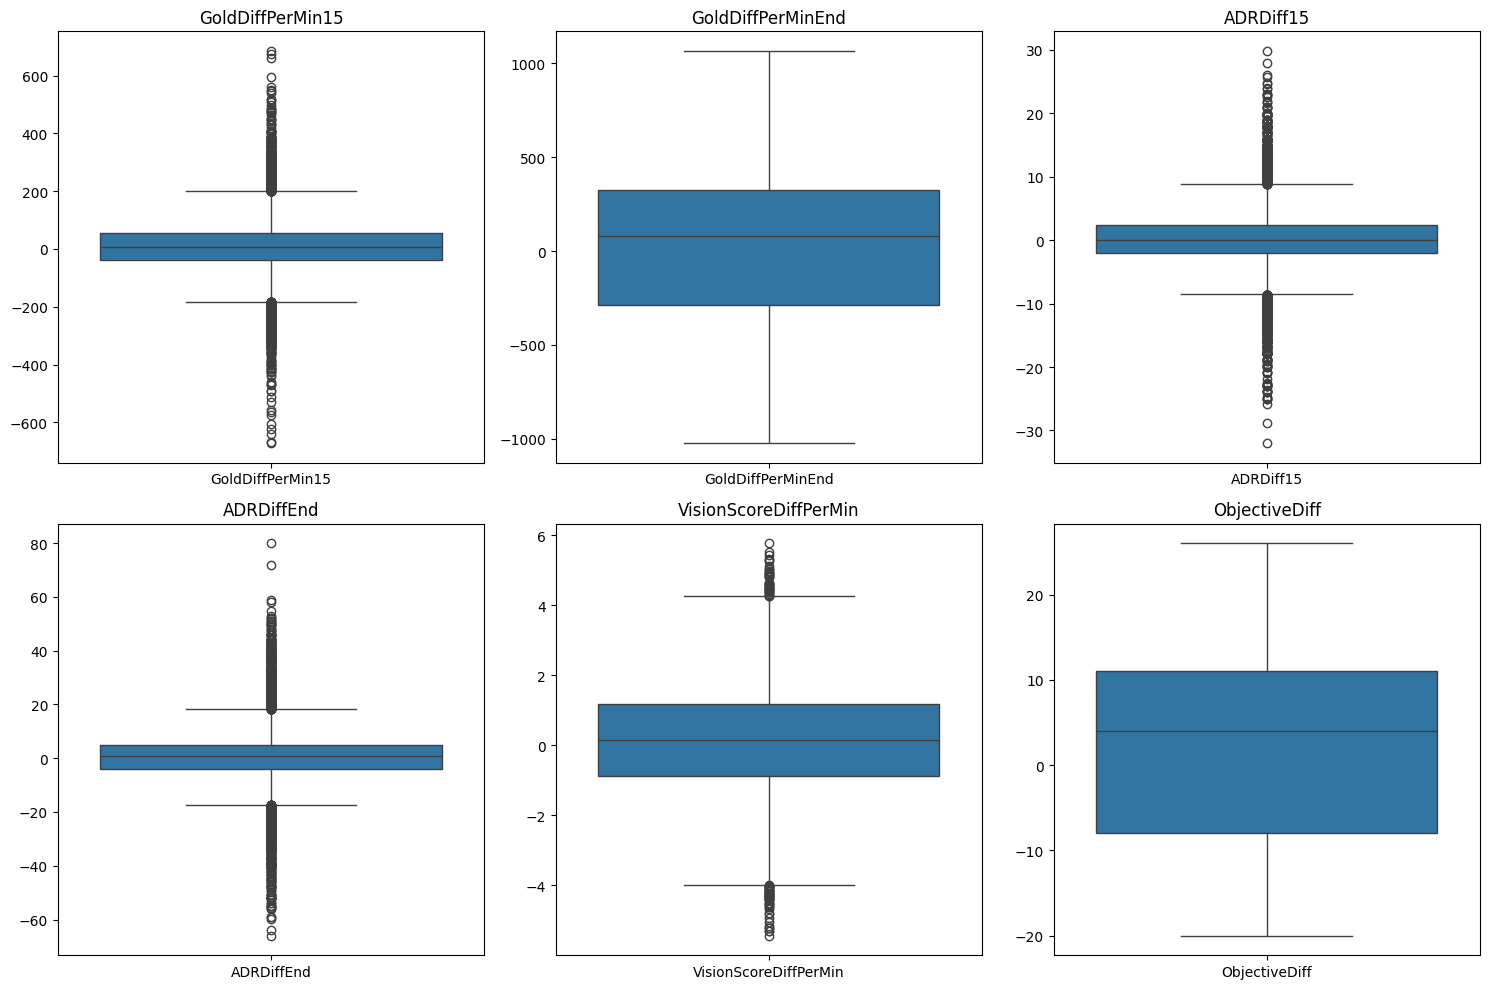

In [69]:
col_list = metrics_df.columns.tolist()
col_list = col_list[1:]

plt.figure(figsize=(15, 10))

for i in range(0, 6):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=metrics_df[[col_list[i]]])
    plt.title(col_list[i])

plt.tight_layout()
plt.show()

We are quite happy with what we're looking at. Let's see how a logistic regression model performs on our parameters after rescaling our features:

In [70]:
scaler = StandardScaler()
metrics_rescaled = scaler.fit_transform(metrics_df[col_list])
metrics_rescaled = pd.DataFrame(data=metrics_rescaled,columns=col_list)
metrics_rescaled

,GoldDiffPerMin15,GoldDiffPerMinEnd,ADRDiff15,ADRDiffEnd,VisionScoreDiffPerMin,ObjectiveDiff
0,-1.287067,-0.882190,-0.724170,-0.242105,-1.019250,-1.062276
1,-0.501214,-1.096570,0.181041,-0.872750,-1.315249,-1.353307
2,0.692675,0.947280,-0.033351,0.457724,0.778513,0.683915
3,0.243682,1.000598,0.102430,0.402916,0.160738,0.780926
4,-0.218958,-0.797273,0.309676,-0.148708,-0.222468,-0.674233
...,...,...,...,...,...,...
19733,-0.321029,0.022726,-1.033847,-0.072576,-0.229177,0.198862
19734,-0.368634,1.118331,0.270371,0.569065,-0.054504,0.683915
19735,-0.095318,-1.046879,0.638411,-0.601825,-1.045969,-0.965265
19736,0.477894,-1.017175,0.331115,-0.986161,-1.001454,-1.256297


In [71]:
#Adel's quick additions after Sarah delivered the data above, using all the data:
logreg = LogisticRegression(max_iter = 500,n_jobs=-1)
y = metrics_df['winner'].apply(lambda x: 1 if x == 'red' else 0)

#Fitting a quick logistic regression to predict whether the winning team is blue or red:
#A high score would indicate some viability.
X_train, X_test, y_train, y_test = train_test_split(metrics_rescaled,y,test_size = 0.3)
logreg.fit(X_train,y_train)
print(logreg.score(X_test,y_test))


0.9922323539344816


In [72]:
logreg.coef_

array([[ 1.10810138, -6.57130344,  0.11065013, -2.61303052,  0.90034042,
        -3.83427843]])

In [73]:
logreg.intercept_

array([-0.37437788])

A 99% success rate at predicting winners seems very convincing at this point.

Now, not all of the data is good to go; for instance, Tim's data has some missing fields, and it will be impossible for us to obtain all the per-15 values out there.

In [74]:

metrics_partial_data = metrics_rescaled.drop(columns=['GoldDiffPerMin15','ADRDiff15'])
logreg_partial = LogisticRegression(max_iter = 500,n_jobs=-1)

Xi_train, Xi_test, yi_train, yi_test = train_test_split(metrics_partial_data,y,test_size = 0.3)
logreg_partial.fit(Xi_train,yi_train)
print(logreg_partial.score(Xi_test,yi_test))
#We don't lose out much. This is promising. Very.

0.9922323539344816


In [75]:
logreg_partial.coef_

array([[-6.3082739 , -3.062366  ,  0.97177802, -3.6316471 ]])

In [76]:
logreg_partial.intercept_

array([-0.50009016])

Considering that we barely lose 0.5% in our score, it would be a much safer approach to consider a model with four features - one that fits partial data.

From here, we can infer points for every game by multiplying the transformed data by the coefficients.

In [77]:
logreg_partial.coef_.shape

(1, 4)

In [78]:
for index, col in enumerate(metrics_partial_data.columns):
    metrics_partial_data[col]*=logreg_partial.coef_[0,index]

metrics_partial_data.head()

,GoldDiffPerMinEnd,ADRDiffEnd,VisionScoreDiffPerMin,ObjectiveDiff
0,5.565097,0.741413,-0.990484,3.857810
1,6.917464,2.672681,-1.278130,4.914735
2,-5.975702,-1.401718,0.756542,-2.483740
3,-6.312043,-1.233877,0.156202,-2.836048
4,5.029420,0.455397,-0.216189,2.448577


In [79]:
metrics_partial_data['gameScore'] = metrics_partial_data.sum(axis=1)
metrics_partial_data.head()

,GoldDiffPerMinEnd,ADRDiffEnd,VisionScoreDiffPerMin,ObjectiveDiff,gameScore
0,5.565097,0.741413,-0.990484,3.857810,9.173836
1,6.917464,2.672681,-1.278130,4.914735,13.226750
2,-5.975702,-1.401718,0.756542,-2.483740,-9.104618
3,-6.312043,-1.233877,0.156202,-2.836048,-10.225767
4,5.029420,0.455397,-0.216189,2.448577,7.717204


Let's examine our scores to see if there is a sign of a standard distribution or whatnot.

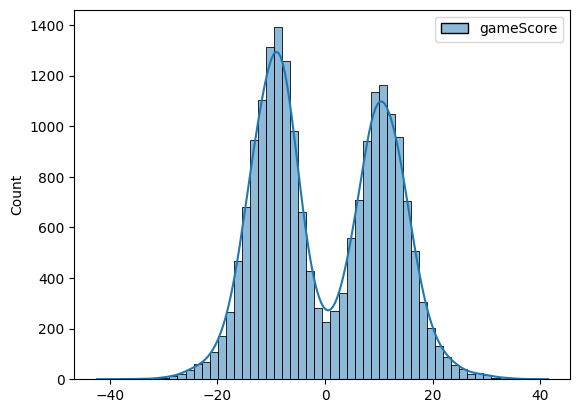

In [89]:
sns.histplot(metrics_partial_data[['gameScore']],kde=True)
plt.show()

Newsflash: we have blue side bias, folks! At least overall. Maybe it's different on a patch-to-patch basis, but overall, we are skewed towards a blue bias. Note the values > 0 (red side wins).

In [81]:
metrics_partial_data[['gameScore']].describe()

,gameScore
count,1.973800e+04
mean,6.335775e-17
std,1.160233e+01
min,-4.236913e+01
25%,-9.833278e+00
50%,-2.478952e+00
75%,1.039071e+01
max,4.138112e+01
